# Setup

In [3]:
# requires
# pip install git+https://github.com/Phylliida/MambaLens.git

# do PCA (and projective PCA?)
# todo: for each name look at its PCA (make a colored graph for different components?)
# train projection from PCA space to classifier space?

from mamba_lens import HookedMamba # this will take a little while to import
import torch
model_path = "state-spaces/mamba-370m"
model = HookedMamba.from_pretrained(model_path, device='cuda')
torch.set_grad_enabled(False)


/opt/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Moving model to device:  cuda


In [4]:
# pip install git+https://github.com/Phylliida/MambaLens.git
# pip install git+https://github.com/Phylliida/ACDC.git
from acdc.data.ioi import ioi_data_generator, ABC_TEMPLATES, get_all_single_name_abc_patching_formats
from acdc.data.utils import generate_dataset

num_patching_pairs = 10000
seed = 27
valid_seed = 28
constrain_to_answers = True
has_symmetric_patching = True

templates = ABC_TEMPLATES
patching_formats = list(get_all_single_name_abc_patching_formats())

data = generate_dataset(model=model,
                  data_generator=ioi_data_generator,
                  num_patching_pairs=num_patching_pairs,
                  seed=seed,
                  valid_seed=valid_seed,
                  constrain_to_answers=constrain_to_answers,
                  has_symmetric_patching=has_symmetric_patching, 
                  varying_data_lengths=True,
                  templates=templates,
                  patching_formats=patching_formats)



# Find positions of names for each piece of data

In [5]:
from acdc.data.ioi import good_names
from collections import defaultdict
name_tokens = set([model.to_single_token(" " + name) for name in good_names])

print(name_tokens)
print(data.data.size())
name_positions = defaultdict(lambda: [])
for i in range(data.data.size()[0]):
    prompt_tokens = data.data[i]
    name_pos = 0
    for i, tok in enumerate(prompt_tokens):
        if tok.item() in name_tokens:
            name_positions[name_pos].append(i) # +1 because conv
            name_pos += 1
    if name_pos != 5: raise ValueError(f"data point {model.to_str_tokens(data)} does not have 5 names")

{50178, 46600, 31755, 46604, 11276, 33811, 46612, 16916, 18966, 12824, 32794, 7195, 33821, 33313, 37921, 29222, 31270, 28200, 18985, 37930, 28712, 7727, 24112, 32817, 36400, 5171, 44085, 35382, 30274, 20554, 15435, 33357, 49231, 38994, 21587, 7252, 40537, 27738, 44123, 44124, 14943, 45664, 15458, 49765, 19046, 35944, 29804, 23662, 37497, 22138, 27773, 28798, 33407, 27264, 9857, 35972, 6277, 14468, 4744, 32393, 32905, 22671, 20628, 17560, 32920, 21661, 16543, 31903, 16553, 18089, 41131, 28331, 20145, 46262, 30397, 41151, 22723, 23239, 17100, 37073, 22739, 49365, 16598, 47831, 31959, 22234, 23259, 20189, 45790, 29927, 46312, 46831, 29936, 31472, 26355, 6393, 8444, 26876, 26878, 6911, 25856, 19717, 8966, 38150, 26888, 27917, 6416, 39184, 24336, 48401, 23316, 37144, 31513, 42266, 29989, 27434, 45867, 36139, 29489, 27955, 27443, 22838, 7993, 13114, 13629, 28991, 40771, 25413, 44870, 18247, 47944, 26953, 35657, 13651, 27991, 26456, 48990, 34655, 16225, 28518, 20839, 43367, 10092, 11116, 3108

# Compute the embedding averages for each (name, position) 

In [6]:
import torch
from tqdm.notebook import tqdm

LAYER = 39
batch_size = 40

hook = f"blocks.{LAYER}.hook_ssm_input"

name_averages = defaultdict(lambda: {})
counts = defaultdict(lambda: {})

TOTAL_AVG_NAME = "total"

for tok in name_tokens:
    for name_i in range(len(name_positions)):
        name_averages[name_i][tok] = torch.zeros([model.cfg.E], device=model.cfg.device)
        counts[name_i][tok] = 0

for batch_start in tqdm(list(range(0, data.data.size()[0], batch_size))):
    batch_end = min(data.data.size()[0], batch_start+batch_size)
    data_batch = data.data[batch_start:batch_end]
    logits, activations = model.run_with_cache(data_batch, names_filter=[hook], fast_ssm=True, fast_conv=True)
    for name_i in range(len(name_positions)):
        positions = torch.tensor(name_positions[name_i][batch_start:batch_end], device=model.cfg.device)
        batch_name_tokens = data_batch[torch.arange(batch_end-batch_start),positions]
        ssm_inputs = activations[hook]
        for batch_i, name_tok in enumerate(batch_name_tokens):
            try:
                position = positions[batch_i]+1 # one plus position, because of convs
                name_averages[name_i][name_tok.item()] += ssm_inputs[batch_i, position]
                counts[name_i][name_tok.item()] += 1
            except:
                print(model.to_str_tokens([name_tok]))
                raise
print("frequency of each name:")
print(counts)
for name_i in range(len(name_positions)):
    for name_tok in list(name_averages[name_i].keys()):
        name_averages[name_i][name_tok] = name_averages[name_i][name_tok] / counts[name_i][name_tok]


  0%|          | 0/1000 [00:00<?, ?it/s]

frequency of each name:
defaultdict(<function <lambda> at 0x7fd363fecdc0>, {0: {50178: 196, 46600: 204, 31755: 178, 46604: 178, 11276: 162, 33811: 200, 46612: 190, 16916: 190, 18966: 164, 12824: 200, 32794: 212, 7195: 238, 33821: 192, 33313: 200, 37921: 178, 29222: 208, 31270: 202, 28200: 168, 18985: 180, 37930: 240, 28712: 196, 7727: 222, 24112: 218, 32817: 170, 36400: 182, 5171: 172, 44085: 222, 35382: 204, 30274: 172, 20554: 160, 15435: 168, 33357: 216, 49231: 190, 38994: 150, 21587: 232, 7252: 200, 40537: 194, 27738: 224, 44123: 238, 44124: 236, 14943: 148, 45664: 200, 15458: 206, 49765: 198, 19046: 154, 35944: 156, 29804: 186, 23662: 206, 37497: 200, 22138: 242, 27773: 188, 28798: 150, 33407: 186, 27264: 218, 9857: 234, 35972: 230, 6277: 226, 14468: 222, 4744: 166, 32393: 190, 32905: 224, 22671: 170, 20628: 178, 17560: 214, 32920: 348, 21661: 188, 16543: 206, 31903: 184, 16553: 182, 18089: 198, 41131: 230, 28331: 174, 20145: 222, 46262: 188, 30397: 178, 41151: 208, 22723: 182, 232

# Modify activations of ssm_input and see how that changes the output

change DO_DIFF to switch method

In [9]:
import random
random.seed(27)

# True or False specifices which we do (False is "Replace Method", True is "Add and Subtract Method")
DO_DIFF = True

model_kwargs = {"fast_ssm": True, "fast_conv": True}

original_corrects = {}
original_replaces = {}
replace_corrects = {}
replace_replaces = {}
patched_corrects = {}
patched_replaces = {}

for position_1 in range(5):
    for position_2 in range(5):
        print(position_1, position_2)
        original_correct = []
        original_replace = []
        replace_correct = []
        replace_replace = []
        patched_correct = []
        patched_replace = []

        original_corrects[(position_1, position_2)] = original_correct
        original_replaces[(position_1, position_2)] = original_replace
        replace_corrects[(position_1, position_2)] = replace_correct
        replace_replaces[(position_1, position_2)] = replace_replace
        patched_corrects[(position_1, position_2)] = patched_correct
        patched_replaces[(position_1, position_2)] = patched_replace

        batched_inputs = []
        batched_corrupted_inputs = []
        num_found = 0
        hooks = []
        corrupted_hooks = []
        last_token_positions = []
        replace_toks = []
        answer_toks = []
        batch_i = 0
        while True:
            data_i = random.choice(list(range(data.data.size()[0])))
            
            import random
            from functools import partial
        
            data_i = (data_i // 2)*2
            patched_i = data_i + 1
            
            data_tokens = data.data[data_i]
            corrupted_tokens = data.data[patched_i]
            answer_tok = data.correct[data_i][0].item()
            answer = model.to_str_tokens(torch.tensor([answer_tok]))[0]
            replace_tok = data.correct[patched_i][0].item()
            new_answer_tok = replace_tok
            if position_1 > 2:
                # replacing patched name for 3 and 4 wouldn't change the output
                # instead, we need to substitute the answer
                # this results in a different answer being outputted (the name that isn't present)
                replace_tok = answer_tok
                # find the new answer, which is the name at the position we are overwriting
                token_position_of_new_answer = name_positions[position_1][data_i]
                new_answer_tok = data.data[data_i][token_position_of_new_answer].item()
                
                        
            replace_name = model.to_str_tokens(torch.tensor([replace_tok]))[0]
            
            last_token_pos = data.last_token_position[data_i]
            def replace_hook(
                x,
                hook,
                position,
                replace_vec,
                replace_add_vec,
                batch_i,
            ):
                if not replace_vec is None:
                    x[batch_i, position] = replace_vec
                if not replace_add_vec is None:
                    x[batch_i, position] += replace_add_vec
                return x
            
            answer_positions = []
            if position_1 < 3:
                for name_i in range(len(name_positions)):
                    position = name_positions[name_i][data_i]
                    if data_tokens[position].item() == answer_tok:
                        answer_positions.append((name_i, position))
            else:
                answer_positions.append((position_1, name_positions[position_1][data_i]))

            bad = False
            for name_i, position in answer_positions:
                # throw out data points that don't have the answer at the desired position
                # this ensures that we patch the token corresponding to the answer
                # (only relevant for names 0-2, for names 3-4 we substitute the answer always)
                if (position_1 <= 2 and not name_i == position_1) or len(answer_positions) > 2:
                    bad = True
                    break
                
                replace_vec = name_averages[position_2][replace_tok]
                
                if position_1 <= 2:
                    replace_add_vec = name_averages[position_2][replace_tok] - name_averages[position_2][answer_tok]
                else:
                    # we need to subtract the name that was here (now the new answer) and add the replace_tok 
                    replace_add_vec = name_averages[position_2][replace_tok] - name_averages[position_2][new_answer_tok]
        
                if DO_DIFF:
                    hooks.append((hook, partial(replace_hook, position=position+1, replace_vec=None, replace_add_vec=replace_add_vec, batch_i=batch_i)))
                else:
                    hooks.append((hook, partial(replace_hook, position=position+1, replace_vec=replace_vec, replace_add_vec=None, batch_i=batch_i)))
            if bad:
                continue
            else:
                num_found += 1
            
            if num_found % 10 == 0:
                print(num_found)
            batched_inputs.append(data_tokens.view(1, -1))
            last_token_positions.append(last_token_pos)
            replace_toks.append(new_answer_tok)
            answer_toks.append(answer_tok)

            batch_i += 1
            
            if num_found > 100:
                break

        batched_inputs = torch.cat(batched_inputs, dim=0)
        
        logits_modified = model.run_with_hooks(batched_inputs, fwd_hooks=hooks, **model_kwargs)
        
        for i in range(batched_inputs.size()[0]):
            replace_correct.append(logits_modified[i,last_token_positions[i],answer_toks[i]].item())
            replace_replace.append(logits_modified[i,last_token_positions[i],replace_toks[i]].item())        
        del logits_modified
        


0 0
10
20
30
40
50
60
70
80
90
100
0 1
10
20
30
40
50
60
70
80
90
100
0 2
10
20
30
40
50
60
70
80
90
100
0 3
10
20
30
40
50
60
70
80
90
100
0 4
10
20
30
40
50
60
70
80
90
100
1 0
10
20
30
40
50
60
70
80
90
100
1 1
10
20
30
40
50
60
70
80
90
100
1 2
10
20
30
40
50
60
70
80
90
100
1 3
10
20
30
40
50
60
70
80
90
100
1 4
10
20
30
40
50
60
70
80
90
100
2 0
10
20
30
40
50
60
70
80
90
100
2 1
10
20
30
40
50
60
70
80
90
100
2 2
10
20
30
40
50
60
70
80
90
100
2 3
10
20
30
40
50
60
70
80
90
100
2 4
10
20
30
40
50
60
70
80
90
100
3 0
10
20
30
40
50
60
70
80
90
100
3 1
10
20
30
40
50
60
70
80
90
100
3 2
10
20
30
40
50
60
70
80
90
100
3 3
10
20
30
40
50
60
70
80
90
100
3 4
10
20
30
40
50
60
70
80
90
100
4 0
10
20
30
40
50
60
70
80
90
100
4 1
10
20
30
40
50
60
70
80
90
100
4 2
10
20
30
40
50
60
70
80
90
100
4 3
10
20
30
40
50
60
70
80
90
100
4 4
10
20
30
40
50
60
70
80
90
100


# Plot results

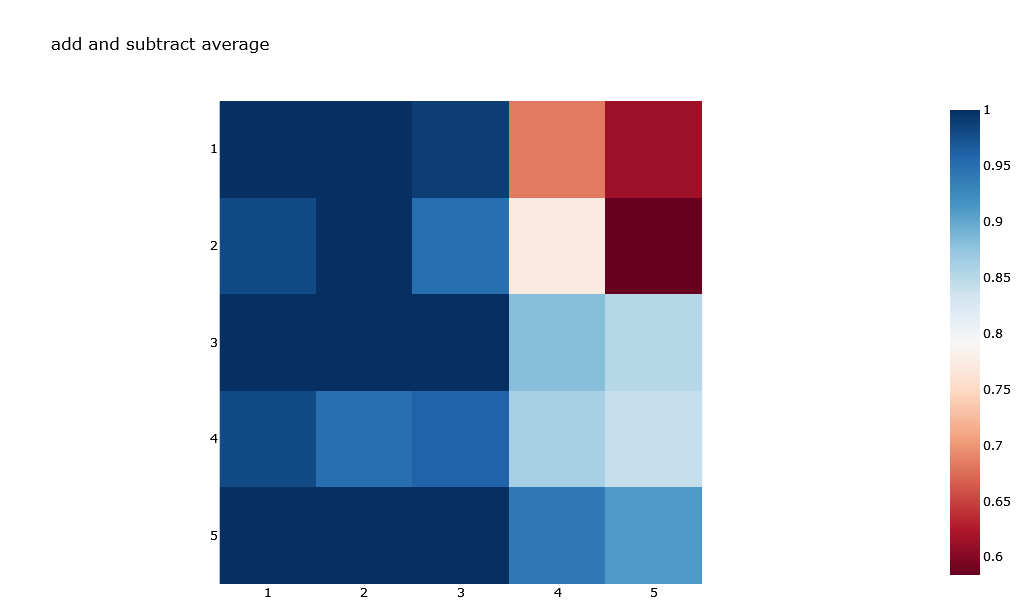

In [10]:

n_correct_matrix = torch.zeros([5,5])

for pos1 in range(5):
    for pos2 in range(5):
        replace_diff = -torch.tensor(replace_corrects[(pos1,pos2)]) + torch.tensor(replace_replaces[(pos1,pos2)])
        n_correct_matrix[pos1, pos2] = torch.sum(replace_diff > 0)/replace_diff.size()[0]

# modified from neel nanda's examples
def imshow(tensor, renderer=None, xaxis="", yaxis="", font_size=None, show=True, color_continuous_midpoint=0.0, **kwargs):
    import plotly.express as px
    import transformer_lens.utils as utils
    fig = px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=color_continuous_midpoint, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs)
    if not font_size is None:
        if 'x' in kwargs:
            fig.update_layout(
              xaxis = dict(
                tickmode='array',
                tickvals = kwargs['x'],
                ticktext = kwargs['x'], 
                ),
               font=dict(size=font_size, color="black"))
        if 'y' in kwargs:
            fig.update_layout(
              yaxis = dict(
                tickmode='array',
                tickvals = kwargs['y'],
                ticktext = kwargs['y'], 
                ),
               font=dict(size=font_size, color="black"))
    plot_args = {
        'width': 800,
        'height': 600,
        "autosize": False,
        'showlegend': True,
        'margin': {"l":0,"r":0,"t":100,"b":0}
    }
    
    fig.update_layout(**plot_args)
    fig.update_layout(legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
            x=0.01
    ))
    if show:
        fig.show(renderer)
    else:
        return fig

title = 'replacing with average'
if DO_DIFF:
    title = 'add and subtract average'

imshow(n_correct_matrix, color_continuous_midpoint=None, y=[1,2,3,4,5], x=[1,2,3,4,5], title=title, font_size=12)